# Práctica Final: Clasificación con Scikit-learn y MLflow

En esta práctica, utilizarás un conjunto de datos de Scikit-learn (podeís usar el mismo que en el notebook de Intro MLFlow) para entrenar un modelo de clasificación.

Pasos a seguir: 

    Exploración de Datos: Analiza el conjunto de datos proporcionado para comprender su estructura y contenido.

    Preprocesamiento de Texto: Realiza tareas de preprocesamiento de texto, como tokenización y vectorización, para preparar los datos para el modelado.

    Entrenamiento del Modelo: Utiliza algoritmos de clasificación de Scikit-learn para entrenar un modelo con los datos preprocesados.

    Evaluación del Modelo: Evalúa el rendimiento del modelo utilizando métricas de evaluación estándar como precisión y recall.

    Registro de Métricas con MLflow: Utiliza MLflow para registrar métricas y hiperparámetros durante el entrenamiento, facilitando la gestión y comparación de experimentos.


Nota: Dado que no voy a poder tener acceso a vuestros logs de MLFlow añadirme las imagenes de la interfaz de MLFlow en el notebook

In [1]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, precision_score, recall_score,ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.datasets import load_wine

Info to understand the ataset:

"The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the three types of wine."

In [2]:
#Cargo el dataset: 
wine = load_wine()

In [3]:
df_wine = pd.DataFrame(wine['data'], columns=wine['feature_names'])
df_wine['target'] = wine['target']
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [4]:
print(f"The shape of the dataset is:", {df_wine.shape})
print(df_wine.describe())


The shape of the dataset is: {(178, 14)}
          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.1

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64


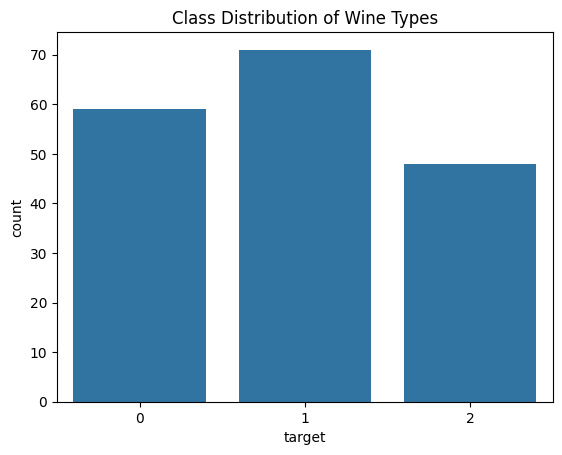

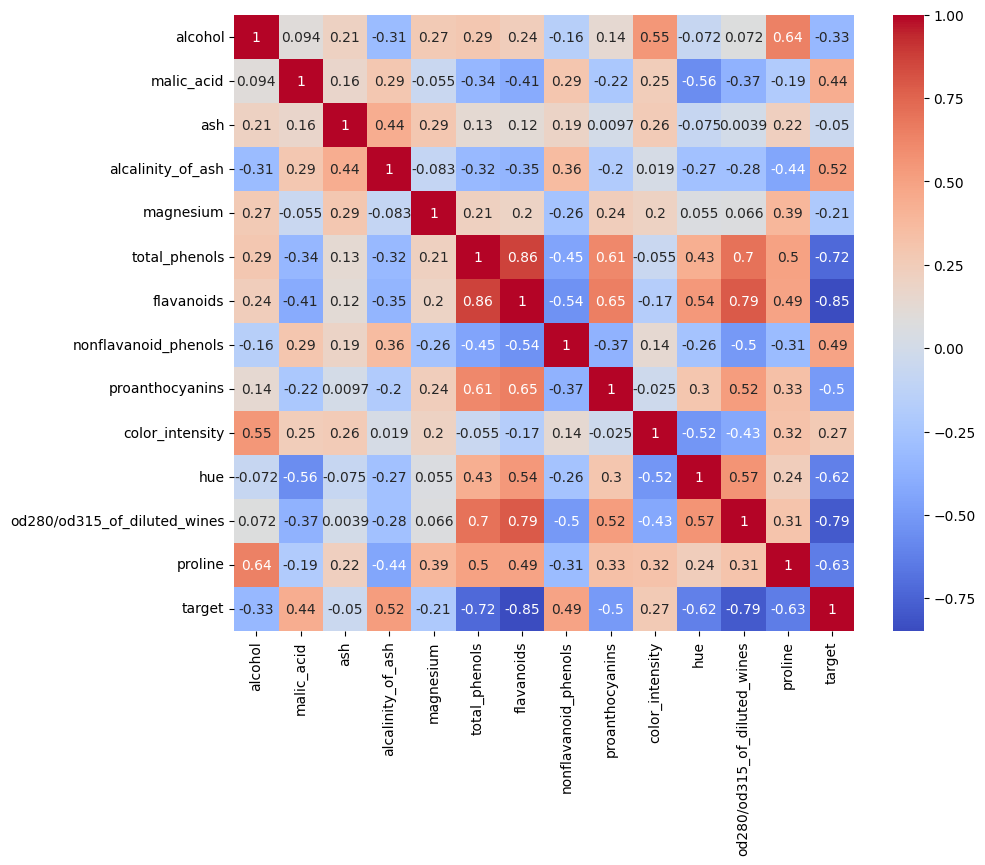

In [5]:
#Análisis de datos

import seaborn as sns
import matplotlib.pyplot as plt

# Check for missing values
print(df_wine.isnull().sum())

# Class distribution
sns.countplot(x=df_wine['target'])
plt.title("Class Distribution of Wine Types")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_wine.corr(), annot=True, cmap="coolwarm")
plt.show()


In [6]:
# Drop features with correlation >= 0.85

df_wine.drop(columns='flavanoids', inplace=True)
df_wine.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'nonflavanoid_phenols', 'proanthocyanins',
       'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline',
       'target'],
      dtype='object')

In [7]:
#Data Preprocessing: Split data into train and test sets and Scale features using StandardScaler

# Split data into features and target
X = df_wine.drop(columns=['target'])
y = df_wine['target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [8]:
#I will try Logistic Regression as a Classification Model and then use Grid Search to fine-tune the model

# Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(random_state=42, class_weight= 'balanced'))
])

param_grid = {
    'logistic_regression__C': [0.01, 0.1, 1, 10, 100],
    'logistic_regression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'logistic_regression__max_iter': [1000, 2000, 5000]
}

# Cross-Validation Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Best Parameters: {'logistic_regression__C': 10, 'logistic_regression__max_iter': 1000, 'logistic_regression__solver': 'newton-cg'}
Confusion Matrix:
 [[12  0  0]
 [ 0 14  0]
 [ 0  1  9]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.93      1.00      0.97        14
           2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36


Accuracy Score: 0.9722222222222222


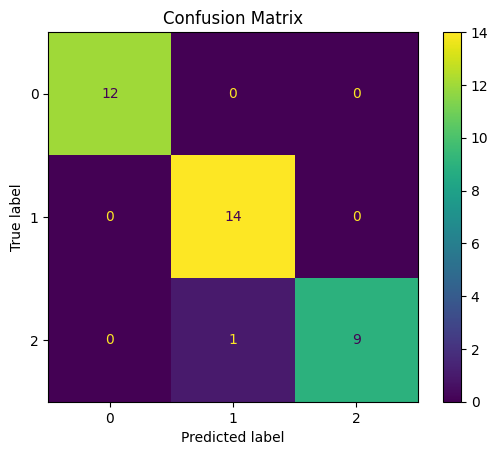

In [9]:
#Calculate to save in mlflow:

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


report = classification_report(y_test, y_pred, output_dict=True)

# The Confusion Matrix: it has to be log as an external file
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")

#plt.show()



In [10]:

#In mlflow I will log: hyperparameter, metrics, model, report and confusion matrix

mlflow.set_experiment("Wines_classification_1")
with mlflow.start_run(run_name="Despliegue_practica"):
  mlflow.log_param("model", "Logistic Regression")
  mlflow.log_param("solver", grid_search.best_params_["logistic_regression__solver"])
  mlflow.log_param("C", grid_search.best_params_["logistic_regression__C"])
  mlflow.log_param("max_iter", grid_search.best_params_["logistic_regression__max_iter"])

  mlflow.log_metric("accuracy", accuracy)
  mlflow.log_metric("precision", precision)
  mlflow.log_metric("recall", recall)
  mlflow.log_metric("f1_score", f1)

  mlflow.log_dict(report, "classification_report.json")
  mlflow.log_artifact("confusion_matrix.png")
  
  mlflow.sklearn.log_model(grid_search.best_estimator_, "wine_classifier_model")
     

2025/02/23 19:10:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


![mlflow run](mlflow_example.png)

In [11]:
#Now, I will save the model but without GridSearch, to see in mlflow how it change when "C parameter" changes

import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, precision_score, recall_score,ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_wine

#Load the dataset: 
wine = load_wine()
df_wine = pd.DataFrame(wine['data'], columns=wine['feature_names'])
df_wine['target'] = wine['target']

# Drop features with correlation >= 0.85
df_wine.drop(columns='flavanoids', inplace=True)

# Split data into features and target
X = df_wine.drop(columns=['target'])
y = df_wine['target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Pipeline

c_values = [0.01, 0.10, 1.00, 10.00, 100.00]

mlflow.set_experiment('Test_different_C_values')
for c in c_values:
    with mlflow.start_run() as run:
    
    # Create Pipeline
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression(C=c,solver= 'newton-cg',max_iter=1000,random_state=42, class_weight= 'balanced'))
        ])
    
    # Train the model
        pipeline.fit(X_train, y_train)
        accuracy_train = pipeline.score(X_train, y_train)
        pipeline.score(X_test, y_test)
    
    # Make predictions
        y_pred = pipeline.predict(X_test)

    #log the metrics in mlflow
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        mlflow.log_param("C", c)
        mlflow.log_metric("accuraty_train", accuracy_train)
        mlflow.sklearn.log_model(pipeline, 'lr_model')

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)


2025/02/23 19:10:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/23 19:10:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/23 19:10:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/23 19:10:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/23 19:11:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


![mlflow run c_values](mlflow_cvalues.png)

## Generar .py de funciones y main con al menos dos argumentos de entrada.

In [13]:
%%writefile functions.py

import argparse
import subprocess
import time
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score
from sklearn.datasets import load_wine

def arguments():
    print("probaaandoo")
    parser = argparse.ArgumentParser(description='__main__ arguments as inputs')
    parser.add_argument('--name_job', type=str, help='Add name parameter of the job: name_job')
    parser.add_argument('--c_values', nargs='+', type=int, help='List of c_values')
    return parser.parse_args()

def load_dataset():
    wine = load_wine()
    df_wine = pd.DataFrame(wine['data'], columns=wine['feature_names'])
    df_wine['target'] = wine['target']
    return df_wine


def data_processing(df_wine):
    # Drop features with correlation >= 0.85
    df_wine.drop(columns='flavanoids', inplace=True)

    # Split data into features and target
    X = df_wine.drop(columns=['target'])
    y = df_wine['target']

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    return X_train, X_test, y_train, y_test
    

def mlflow_tracking(name_job, X_train, X_test, y_train, y_test, c_values):
    mlflow_ui_process = subprocess.Popen(['mlflow', 'ui', '--port', '5000'])
    print(mlflow_ui_process)
    time.sleep(5)
    mlflow.set_experiment(name_job)
    for c in c_values:
        with mlflow.start_run() as run:
            pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('logistic_regression', LogisticRegression(C=c,solver= 'newton-cg',max_iter=1000,random_state=42, class_weight= 'balanced'))
            ])

            pipeline.fit(X_train, y_train)
            accuracy_train = pipeline.score(X_train, y_train)
            pipeline.score(X_test, y_test)

            mlflow.log_metric('accuracy_train', accuracy_train)
            mlflow.log_param("C", c)
            mlflow.sklearn.log_model(pipeline, 'lr_model')
       
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1_score", f1)

    return print("Se ha acabado el entrenamiento del modelo correctamente")





Writing functions.py


In [14]:
%%writefile main.py

from functions import arguments, load_dataset, data_processing, mlflow_tracking

def main():
  print("Excuting main.py")
  args_values = arguments()
  df = load_dataset()
  X_train, X_test, y_train, y_test = data_treatment(df)
  mlflow_tracking(args_values.name_job, x_train, x_test, y_train, y_test, args_values.c_values)

if __name__ == "__main__":
  main()

Writing main.py


## Práctica parte FastAPI

### Para esta parte de la práctica teneis que generar un script con al menos 5 modulos app.get y dos de ellos tienen que ser pipelines de HF. 

### Parte de la practica se tendra que entregar en capturas de pantalla. Las capturas de pantalla a adjuntas son las siguientes. 

### 1. Captura de la pantalla docs con al menos 5 modulos. 
### 2. Captura de cada una de los modulos con la respuesta dentro de docs. 
### 3. Captura de cada uno de los modulos en la llamada https.
### 4. Todo el codigo usado durante el proceso. Notebooks y scripts.

### Opcional

### 5. Despliegue del script en GCP Cloud Run